## Part 3

# Evaluating Ground State of Hamiltonian
<br>
<br>

You can find a copy of this presentation at

https://github.com/grossiM/LAB_Quantum_Computation22/tree/main

michele.grossi@cern.ch


## VQE

The Variational Quantum Eigensolver (VQE) is a central algorithm in many applications from e.g. quantum chemistry or optimization.
This tutorial shows you how to run the VQE as a Qiskit Runtime program. We'll start off by defining the algorithm settings, such as the Hamiltonian and ansatz, and then run a VQE using the Qiskit Runtime.

### Installing Qiskit runtime

Anaconda or a pyenv is recommended to manage all dependencies.

*Command:* `pip install pip install qiskit_ibm_runtime`

Qiskit runtime schematic representation:
    
<div>
<img src="images/vqa_with_runtime.png" width="600" align="left"/>
</div>

# Computing Ground State (Classically)

The Ising model is a mathematical model of ferromagnetism in statistical mechanics.
The model consists of discrete variables that represent magnetic dipole moments of atomic spins that can be in one of two states ($+1$ or $−1$).
The spins are arranged in a graph, usually a lattice (where the local structure repeats periodically in all directions), allowing each spin to interact with its neighbors.
Neighboring spins that agree have a lower energy than those that disagree; the system tends to the lowest energy but heat disturbs this tendency, thus creating the possibility of different structural phases. 


Consider a set $\Lambda$ of lattice sites, each with a set of adjacent sites (e.g. a graph) forming a $d$-dimensional lattice.For each lattice site $k \in \Lambda$ there is a discrete variable $\sigma_k$ such that $\sigma_k \in \{+1,-1\}$, representing the site's spin. A spin configuration,$(\sigma_k)_{k \in K} \in \{-1,+1\}^K$ is an assignment of spin value to each lattice site.

For any two adjacent sites $i,j \in \Lambda$ there is an interaction $J_{ij}$. Also a site $j \in \Lambda$ has an external magnetic field hj interacting with it. The energy of a configuration $\sigma$ is given by the Hamiltonian function

\begin{equation}
H(\sigma )=\sum _{\langle i~j\rangle }J_{ij}\sigma _{i}\sigma _{j}+\mu \sum _{j}h_{j}\sigma _{j}
\end{equation}

where the first sum is over pairs of adjacent spins (every pair is counted once). The notation $\langle ij \rangle$ indicates that sites $i$ and $j$ are nearest neighbors. The magnetic moment is given by $\mu$.
Ising models can be classified according to the sign of the interaction: if, for a pair i, j

- ${J_{ij}<0}$, the interaction is called ferromagnetic,
- ${J_{ij}>0}$, the interaction is called antiferromagnetic,
- ${J_{ij}=0}$, the spins are noninteracting.

Now we restrict our analisys in the following way

- Quantum case: $\sigma_i$ are Pauli matrices, precisely $\sigma^z _i$ in the first term and $\sigma^x _i$ in the second term;
- Ferromagnetic Model:${J_{ij}<0}$;
- One dimensional chain: $\Lambda$ is 1d lattice;
- Same interaction: $J_{i,j}=J$;
- Same magnetic interaction: $h_j=h$.

The hamiltonian is given by
\begin{equation}
    H=J\sum_{i }\sigma^z_i\sigma^z_{i+1}+b\sum_j\sigma^x_j
\end{equation}
where $b$ now measures the effect of a external magnetic field on the lattice.


In [3]:
#IMPORT TO BE MOVED UP
import numpy as np
from numpy import linalg
from scipy import linalg


from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.opflow import Z, I, X, Zero, One

In [4]:
#First we write the function for Ising hamiltonian
#We use qubits to represent sites

def H_ising(num_qubits,J,b):
    m=num_qubits-1
    n=num_qubits-2
    G=b*((I^m)^X)
    H=0
    hamiltonian1=H
    hamiltonian2=G
    
    for i in range(n+1):
        H =(I^i)^Z^Z^(I^(n-i))
        G=(I^i)^X^(I^(m-i))
        hamiltonian1=hamiltonian1+J*H
        hamiltonian2=hamiltonian2+b*G
    
    hamiltonian=hamiltonian1+hamiltonian2
    return hamiltonian

In [5]:
#We calculate the Eigenvalues for some values of B (magnetic field)

nShots = 8192
J = -1
b = np.linspace(0,4,10)

num_qubits=4
E_l = []
P_l = []
energy_levels = []

for k in range(len(b)):
    #In order to use linalg.eig we have to use Operator class
    hamiltonian=Operator(H_ising(num_qubits,J,b[k]))
    # Extract eig
    E_l,P_l = linalg.eig(hamiltonian.data)
    Es = np.sort(E_l)
    energy_levels.append(np.real(Es))


In [6]:
##USING built-in qiskit functions
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(hamiltonian)

print(f"Ground state energy is: {sol.eigenvalue} and its relative eigenstate is: {sol.eigenstate}")

Ground state energy is: -16.18774005307964 and its relative eigenstate is: Statevector([-0.30034282+0.j,  0.2628453 +0.j,  0.23226009+0.j,
             -0.26079213+0.j,  0.23226009+0.j, -0.20642572+0.j,
             -0.23044583+0.j,  0.2628453 +0.j,  0.2628453 +0.j,
             -0.23044583+0.j, -0.20642572+0.j,  0.23226009+0.j,
             -0.26079213+0.j,  0.23226009+0.j,  0.2628453 +0.j,
             -0.30034282+0.j],
            dims=(2, 2, 2, 2))


# Computing Ground State (Quantum)
Now we want to calculate the ground state using quantum circuits, we are going to implement VQE algorithms based on our hamiltonian and noise models.  
We split the computation in three different parts:
- Noiseless;

- Noisy, in this case we consider two different model:
    - Custom noise;
    - Hardware noise;
    
- Mitigated.

In [7]:
#Define callback function

intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

## Noiseless

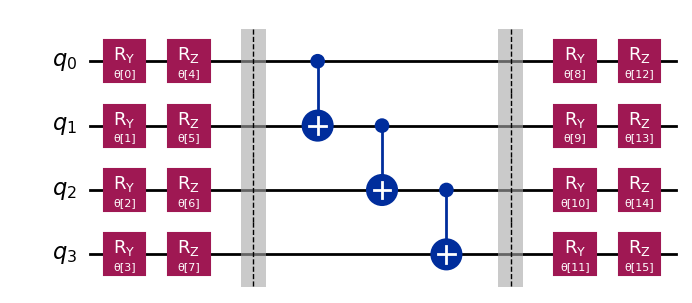

In [15]:
#Define Ansatz, on which the algorithm of VQE starts
from qiskit.circuit.library import EfficientSU2

np.random.seed(1)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
initial_point = np.random.random(ansatz.num_parameters)
ansatz.decompose().draw('mpl', style='iqx')

We will create our service instance and specify our backend. 

In this example we will use a simulator to avoid queue times, but you can use the following code to run on a real device by simply changing the backend.

In [8]:
### Try new part

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options

service = QiskitRuntimeService()
service.backends()

backend = "ibmq_qasm_simulator"

The next code cell specifies how we want to run the VQE. This includes

- the type of circuit (ansatz) used to create our trial state,
- the classical algorithm that decides how to adjust our trial state to achieve better solutions, and the starting parameters.

We will also create a simple object to log our intermediate results for plotting later.

In [30]:
from qiskit.algorithms.minimum_eigensolvers import VQE

# Use RealAmplitudes circuit to create trial states
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes


ansatz = RealAmplitudes(num_qubits, reps=2)

# Search for better states using SPSA algorithm
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(150)

# Set a starting point for reproduceability
import numpy as np

np.random.seed(6)
initial_point = np.random.uniform(-np.pi, np.pi, ansatz.num_parameters)
#initial_point = np.random.random(ansatz.num_parameters)

# Create an object to store intermediate results
from dataclasses import dataclass


@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~350", end="\r", flush=True)


log = VQELog([], [])

The next code cell runs the VQE algorithm. If you chose to run on a real device, the code runs zero-noise extrapolation on the final result to estimate the effects of noise, and guess what the result would be from a noiseless device.

In [36]:
# Main calculation
with Session(service=service, backend=backend) as session:
    options = Options()
    options.optimization_level = 3

    vqe = VQE(
        Estimator(session=session, options=options),
        ansatz,
        optimizer,
        callback=log.update,
        initial_point=initial_point,
    )
    result = vqe.compute_minimum_eigenvalue(hamiltonian)
    print("Experiment complete.".ljust(30))
    print(f"Raw result: {result.optimal_value}")

    if "simulator" not in backend:
        # Run once with ZNE error mitigation
        options.resilience_level = 2
        vqe = VQE(
            Estimator(session=session, options=options),
            ansatz,
            SPSA(1),
            initial_point=result.optimal_point,
        )
        result = vqe.compute_minimum_eigenvalue(hamiltonian)
        print(f"Mitigated result: {result.optimal_value}")

Experiment complete.          
Raw result: -16.0775


### Plotting

Finally, the following code cell plots the intermediate results from the optimization process. The optimization algorithm tweaks the parameters to gradually home in on values that produce lower energies. Provided the algorithm does not get caught in a local minima, this graph will plateau at the electronic ground state energy of the system.

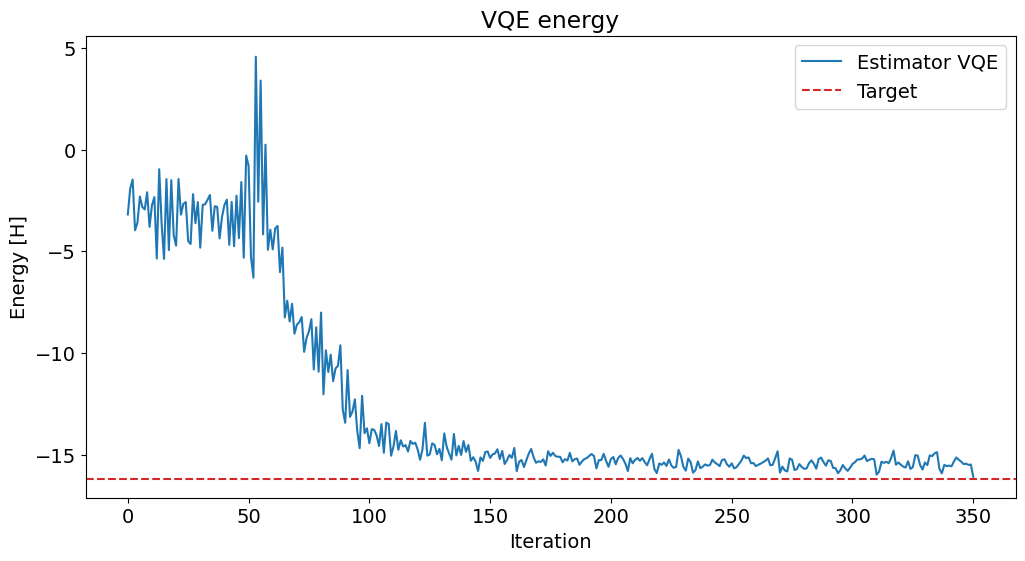

In [39]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=sol.eigenvalue, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

In [40]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.10.0'

In [ ]:
##TRY with different ansatz and optimizer and for different values of B


#ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
#ansatz.decompose().draw('mpl', style='iqx')
#optimizer = COBYLA(maxiter, tol=0.001, rhobeg=1.0)

#for k in range(len(b)):
    #hamiltonian=H_ising(num_qubits,J,b[k])
    
    # Extract eig
    #result = vqe.compute_minimum_eigenvalue(hamiltonian)
    